# Day 6: Attention Mechanisms

## Learning Objectives
- Understand attention mechanism principle
- Implement attention for sequence models
- Visualize attention weights for interpretability

---

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 6: Attention Mechanisms")

✅ Libraries loaded!
📚 Day 6: Attention Mechanisms


## Part 1: The Attention Principle

Instead of using only the final hidden state, **attention** lets the model focus on relevant timesteps:

$$\alpha_t = \text{softmax}(\text{score}(h_t, q))$$
$$\text{context} = \sum_t \alpha_t \cdot h_t$$

**Benefits:**
- Better handles long sequences
- Provides interpretability (which timesteps matter?)
- Captures variable-length dependencies

In [6]:
# ============================================================
# ATTENTION MECHANISM IMPLEMENTATION
# ============================================================

print("ATTENTION MECHANISM")
print("="*60)

class Attention(nn.Module):
    """Additive (Bahdanau) attention mechanism."""
    
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, lstm_outputs):
        """
        Args:
            lstm_outputs: (batch, seq_len, hidden_size)
        Returns:
            context: (batch, hidden_size)
            weights: (batch, seq_len)
        """
        # Compute attention scores
        scores = self.attention(lstm_outputs).squeeze(-1)  # (batch, seq_len)
        
        # Softmax for weights
        weights = torch.softmax(scores, dim=1)
        
        # Weighted sum
        context = torch.bmm(weights.unsqueeze(1), lstm_outputs).squeeze(1)
        
        return context, weights

# Test
attn = Attention(hidden_size=64)
x = torch.randn(4, 20, 64)  # batch=4, seq_len=20, hidden=64
context, weights = attn(x)

print(f"Input:   {x.shape}")
print(f"Context: {context.shape}")
print(f"Weights: {weights.shape}")
print(f"\nWeights sum to 1: {weights.sum(dim=1)}")

ATTENTION MECHANISM
Input:   torch.Size([4, 20, 64])
Context: torch.Size([4, 64])
Weights: torch.Size([4, 20])

Weights sum to 1: tensor([1., 1., 1., 1.], grad_fn=<SumBackward1>)


## Part 2: Attention-LSTM Model

In [7]:
# ============================================================
# ATTENTION-LSTM MODEL
# ============================================================

print("ATTENTION-LSTM MODEL")
print("="*60)

class AttentionLSTM(nn.Module):
    """LSTM with attention for financial prediction."""
    
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = Attention(hidden_size)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x, return_attention=False):
        lstm_out, _ = self.lstm(x)
        context, weights = self.attention(lstm_out)
        output = self.fc(context)
        
        if return_attention:
            return output, weights
        return output

model = AttentionLSTM(input_size=5, hidden_size=64, num_layers=2)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

ATTENTION-LSTM MODEL
Parameters: 55,682


In [8]:
# ============================================================
# PREPARE DATA AND TRAIN
# ============================================================

print("TRAINING ATTENTION-LSTM")
print("="*60)

# Generate data
np.random.seed(42)
n_days = 1000
returns = np.random.normal(0.0002, 0.015, n_days)

for i in range(1, len(returns)):
    returns[i] += 0.15 * returns[i-1]

df = pd.DataFrame({'returns': returns})
df['vol_5d'] = df['returns'].rolling(5).std()
df['vol_20d'] = df['returns'].rolling(20).std()
df['mom_5d'] = df['returns'].rolling(5).mean()
df['mom_20d'] = df['returns'].rolling(20).mean()
df = df.dropna()

features = df.values
scaler = StandardScaler()
features = scaler.fit_transform(features)

seq_len = 20
X, y = [], []
for i in range(len(features) - seq_len):
    X.append(features[i:i+seq_len])
    y.append(features[i+seq_len, 0])

X, y = np.array(X), np.array(y)
split = int(len(X) * 0.8)

X_train, X_test = torch.FloatTensor(X[:split]), torch.FloatTensor(X[split:])
y_train, y_test = torch.FloatTensor(y[:split]).unsqueeze(1), torch.FloatTensor(y[split:]).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# Train
model = AttentionLSTM(input_size=5, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = []
for epoch in range(100):
    model.train()
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_b), y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
    history.append(test_loss)
    
    if (epoch + 1) % 25 == 0:
        print(f"  Epoch {epoch+1}: Test Loss = {test_loss:.6f}")

print("\n✅ Training complete!")

TRAINING ATTENTION-LSTM
  Epoch 25: Test Loss = 1.036846
  Epoch 50: Test Loss = 1.129350
  Epoch 75: Test Loss = 1.236187
  Epoch 100: Test Loss = 1.363980

✅ Training complete!


## Part 3: Visualizing Attention Weights

ATTENTION VISUALIZATION
Direction Accuracy: 46.1%


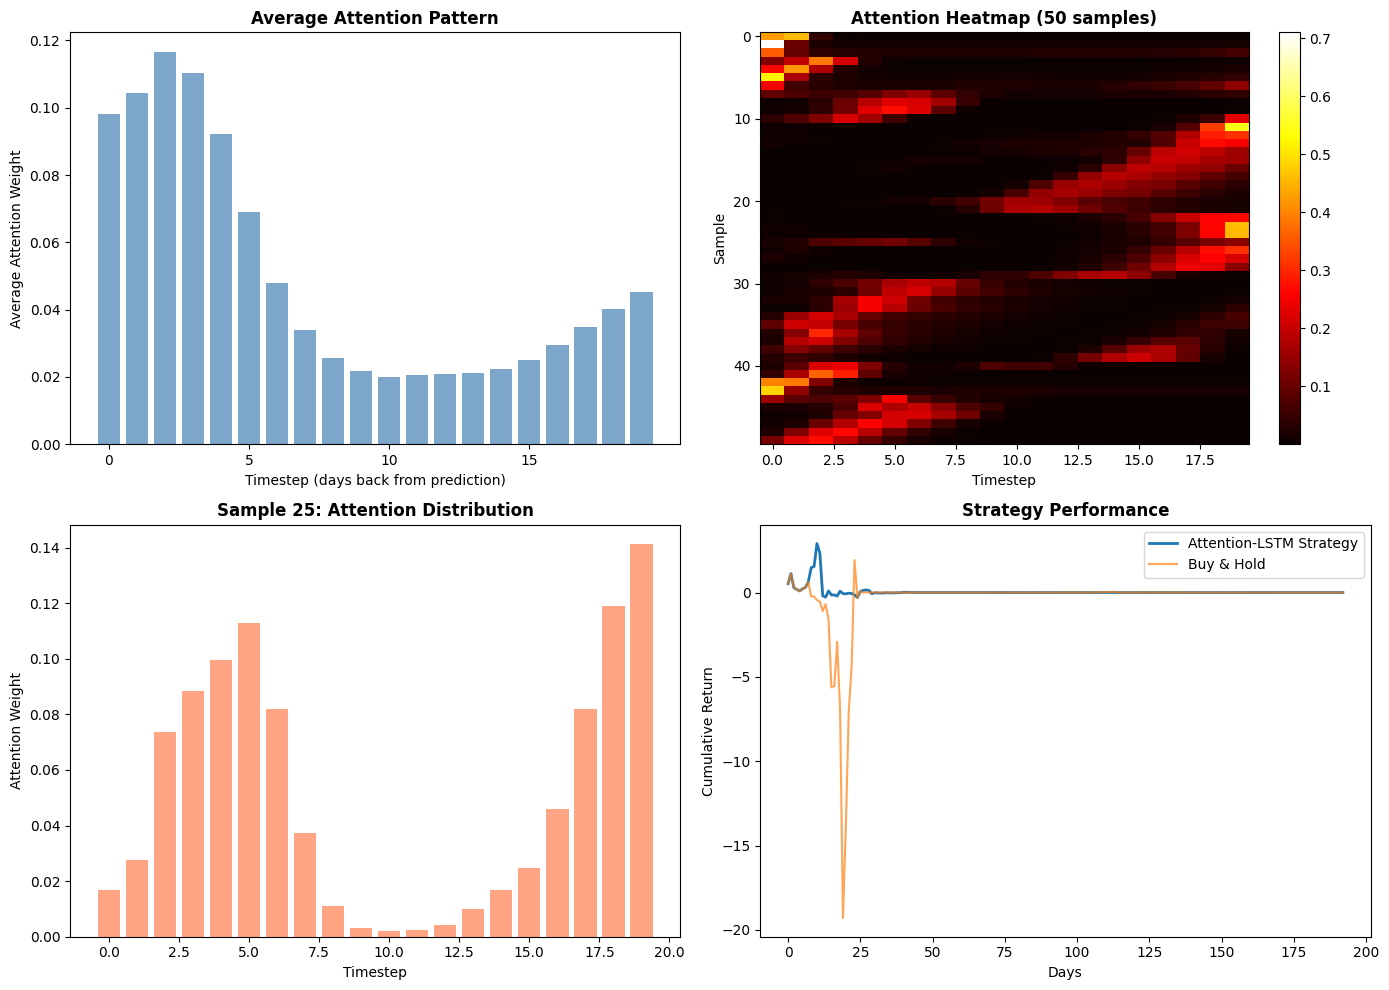


💡 KEY INSIGHT: Attention shows which past days influenced the prediction
   - Higher weights on recent days (recency effect)
   - But some distant days also get attention (patterns!)


In [9]:
# ============================================================
# ATTENTION VISUALIZATION
# ============================================================

print("ATTENTION VISUALIZATION")
print("="*60)

model.eval()
with torch.no_grad():
    preds, attention_weights = model(X_test, return_attention=True)

preds = preds.numpy().flatten()
actuals = y_test.numpy().flatten()
attention_weights = attention_weights.numpy()

# Metrics
direction_acc = np.mean(np.sign(preds) == np.sign(actuals))
print(f"Direction Accuracy: {direction_acc*100:.1f}%")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Average attention
avg_attention = attention_weights.mean(axis=0)
axes[0, 0].bar(range(len(avg_attention)), avg_attention, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Timestep (days back from prediction)')
axes[0, 0].set_ylabel('Average Attention Weight')
axes[0, 0].set_title('Average Attention Pattern', fontweight='bold')
axes[0, 0].set_xticks(range(0, len(avg_attention), 5))

# Attention heatmap for samples
im = axes[0, 1].imshow(attention_weights[:50], aspect='auto', cmap='hot')
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Sample')
axes[0, 1].set_title('Attention Heatmap (50 samples)', fontweight='bold')
plt.colorbar(im, ax=axes[0, 1])

# Single prediction attention
idx = 25
axes[1, 0].bar(range(seq_len), attention_weights[idx], color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Timestep')
axes[1, 0].set_ylabel('Attention Weight')
axes[1, 0].set_title(f'Sample {idx}: Attention Distribution', fontweight='bold')

# Strategy performance
strategy = np.cumprod(1 + actuals * np.sign(preds))
market = np.cumprod(1 + actuals)

axes[1, 1].plot(strategy, label='Attention-LSTM Strategy', linewidth=2)
axes[1, 1].plot(market, label='Buy & Hold', alpha=0.7)
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].set_title('Strategy Performance', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: Attention shows which past days influenced the prediction")
print("   - Higher weights on recent days (recency effect)")
print("   - But some distant days also get attention (patterns!)")

In [10]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║            DAY 6 COMPLETE: ATTENTION MECHANISMS                  ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Attention principle: weighted sum of hidden states           ║
║  ✓ Additive (Bahdanau) attention implementation                 ║
║  ✓ Attention visualization for interpretability                 ║
║  ✓ Which timesteps matter for predictions?                      ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 7 - Complete Sequence Trading Model
""")


╔══════════════════════════════════════════════════════════════════╗
║            DAY 6 COMPLETE: ATTENTION MECHANISMS                  ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Attention principle: weighted sum of hidden states           ║
║  ✓ Additive (Bahdanau) attention implementation                 ║
║  ✓ Attention visualization for interpretability                 ║
║  ✓ Which timesteps matter for predictions?                      ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 7 - Complete Sequence Trading Model

